In [1]:
import numpy as np
import gym
import torch
import random
from torch import nn
from torch import optim
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set('notebook')
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Parameters

In [17]:
REPLAY_BUFFER_SIZE  = 2000
BATCH_SIZE          = 32
EPS_MAX             = 1.0
EPS_MIN             = 0.1
EPS_DECAY_RATE      = 0.995
GAMMA               = 0.95
LR                  = 0.0001
HIDDEN_SIZE         = 64

SEED                = 2

In [18]:
class ActionValueFunction(nn.Module):
    """
    Represents the action-value q(s,a) using a neural network (Deep RL)

    Returns an array containing the value for every action, i.e. q(s,a) = q(s)[a]
    """
    
    def __init__(self):
        super().__init__()
        self.n_inputs = n_features
        self.n_outputs = n_actions
        self.hidden_size = HIDDEN_SIZE
        
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, self.hidden_size), 
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.n_outputs))
    
    def forward(self, state):
        action_probs = self.network(state)
        return action_probs


def run_episode(replay_buffer):
    """
    Run one episode until termination and return the total reward.
    
    Add every step to the replay buffer and update the actionValue network after each step.
    """

    s0 = env.reset()
    a0 = np.random.choice(range(n_actions), p=epsilon_greedy(s0))

    total_reward = 0

    while True:

        s1, r, done, _ = env.step(a0)
        a1 = np.random.choice(range(n_actions), p=epsilon_greedy(s1))
        replay_buffer += [(s0, a0, r, s1, done)]
        s0, a0 = s1, a1

        update()

        total_reward += r
        if done:
            return total_reward


def update():
    """
    Update the actionValue network by sampling experience from the replay buffer
    """

    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = random.choices(replay_buffer, k=BATCH_SIZE)

    s0 = torch.Tensor([b[0] for b in batch]).to(device)
    a0 = torch.LongTensor([b[1] for b in batch]).to(device)
    r = torch.Tensor([b[2] for b in batch]).to(device)
    s1 = torch.Tensor([b[3] for b in batch]).to(device)
    done = torch.BoolTensor([b[4] for b in batch]).to(device)

    if random.random() < 0.5:
        q_a, q_b = q1, q2
        optim = optim1
    else:
        q_a, q_b = q2, q1
        optim = optim2
    
    a_max = torch.argmax(q_a(s1), dim=1)
    q_target = r + ~done * GAMMA * torch.gather(q_b(s1), 1, a_max.unsqueeze(1)).squeeze()
    q_current = torch.gather(q_a(s0), 1, a0.unsqueeze(1)).squeeze()

    loss = torch.nn.functional.mse_loss(q_target, q_current)
    optim.zero_grad()
    loss.backward()
    optim.step()


def epsilon_greedy(s):
    """
    Epsilon-greedy policy
    """

    if random.random() < eps:
        return np.ones(n_actions) / n_actions

    s = torch.Tensor(s).to(device)
    q1_values = q1(s).cpu().detach().numpy()
    q2_values = q2(s).cpu().detach().numpy()
    q_values = (q1_values + q2_values) / 2
    return np.identity(n_actions)[np.argmax(q_values)]


def set_seed(seed):
    """ Sets the seeds """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
env             = gym.make('CartPole-v0')
reward_hist     = []
n_actions       = env.action_space.n
n_features      = env.observation_space.shape[0]

q1              = ActionValueFunction().to(device)
q2              = ActionValueFunction().to(device)

optim1          = torch.optim.Adam(q1.parameters(), lr=LR)
optim2          = torch.optim.Adam(q2.parameters(), lr=LR)
replay_buffer   = deque(maxlen=REPLAY_BUFFER_SIZE)
eps             = EPS_MAX

set_seed(SEED)

for i in range(5000):

    # update epsilon
    eps = max(EPS_MIN, eps * EPS_DECAY_RATE)

    total_reward = run_episode(replay_buffer)
    reward_hist += [total_reward]

    print('\repisode: {} \t average reward (last 100): {:.2f} \t current reward: {:.0f} \t eps: {:.2f}'.format(i, np.mean(reward_hist[-100:]), total_reward, eps), end="")
    
    if np.mean(reward_hist[-100:]) >= 195: break


episode: 1274 	 average reward (last 100): 196.48 	 current reward: 200 	 eps: 0.10

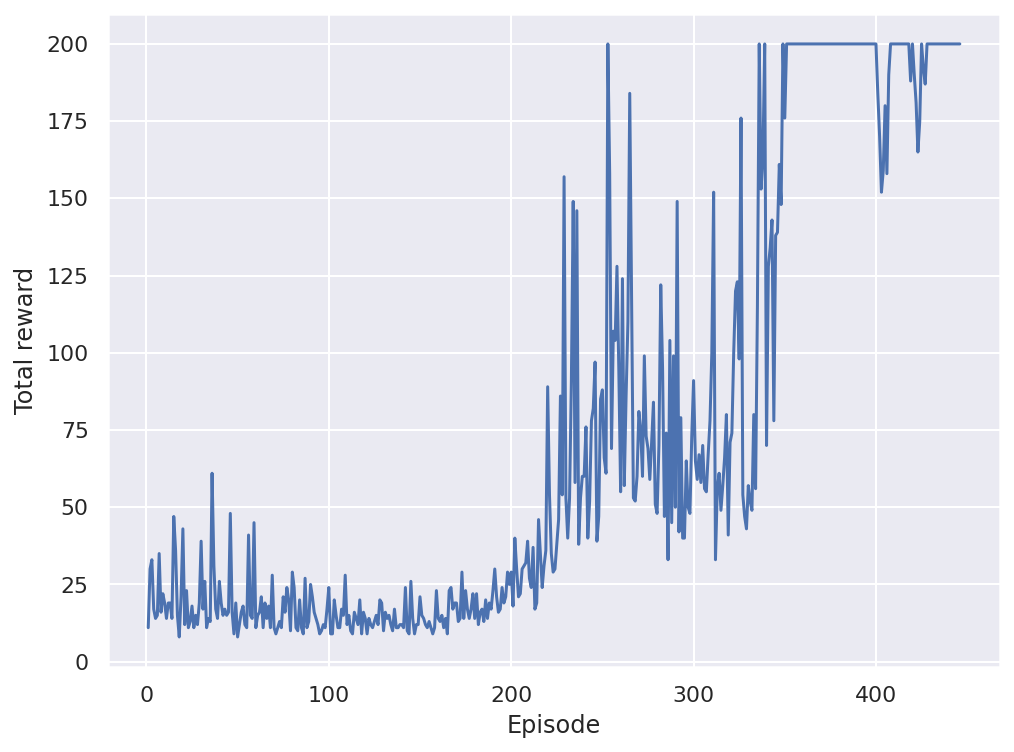

In [10]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1,len(reward_hist)+1), y=reward_hist)
plt.xlabel("Episode")
plt.ylabel("Total reward");

In [ ]:
Double Q-Learning
Priorited Learning
Dueling networks